# Friedel Pairs tutorial
## Introduction

Friedel pairs are symmetric reflections (h,k,l) and (-h,-k,-l) arising from the same grain, which occur at 180° offset during a full 360° rotation of the sample along an axis is perpendicular to the beam. Using symmetric properties of the Friedel pairs, it is possible to clearly seperate the component of the apparent diffraction vectors related to lattice orientation and spacing (the "true" diffraction vector) from the component related to spatial offset from the rotation centre. Identifying Friedel pairs in a 3DXRD dataset thus enables to treat indexing and grain position fitting as two independant problems, which considerably simplifies data analysis, in particular in complex samples such as polyphased, highly strained polycrystaline materials. 

This tutorial focuses on analysis of scanning-3DXRD (or pf-HEXRD) data usig Friedel pairs. In this acquisition mode, the sample is scanned with a pencil beam, which has to be translated multiple times along the y-axis (perpendicular to the beam) to cover a full slice of the sample. The tutorial describes the step-by-step procedure to obtain an indexed grain map starting from segmented diffraction peaks, using data analysis tools available in ImageD11 (https://github.com/FABLE-3DXRD/ImageD11). 

#### Requirements:

- data acquisition has been done applying full 360° rotations of the sample along the z-axis (vertical), in order to get symmetric (h,k,l) and (-h,-k,-l) reflections
- the raw diffraction frames have been segmented into discrete diffraction peaks and stored in a peak table (ImageD11.sinograms).
- A dataset file (ImageD11.sinograms.dataset) containing information about ystep, ybins, etc. has been computed
- detector has been properly calibrated, with calibration parameters (tilt, center, distance, etc.) stored in a parameter file 


#### Examples
Example datasets are provided in the folder /data

SI3_DT360Z5480 is a slice of granite scanned at the 3DXRD workstation of ID11 (ESRF Grenoble, France), using a 50x50 µm pencil beam and angular steps of 0.8°. It contains a diverse mineral assemblage consisting of quartz, biotite, orthoclase (K-feldspar), oligoclase (Plagioclase) and magnetite. Peak segmentation was done using old, deprecated code and has no peak table assigned, so only a peakfile (ImageD11 columnfile saved in hdf format) is provided. This dataset is relatively small and it should be possible to process it on a personal machine without crashing. 

This dataset includes: 
- a peakfile containing 3D peaks (merged in omega): SI3_DT360Z5480_pk3d.h5
- metadata stored in an ImageD11.sinogram.dataset object: SI3_DT360Z5480_ds.h5 
- a parameter file containing detector calibration parameters: SI3.par
In addition, crystal structures for all the minerals mentioned above are provided as cif file in the /cif folder.

other datasets to come (to show how to process data starting from a peaktable)...


## Summary
This tutorial is splitted into four parts, described in different notebooks:

1 - Friedel pair labeling: Find pairs of symmetric reflections in a peak table, assign them a label and store the paired peaks in a new ImageD11 columnfile

2 - Point-by-point phase labeling: assign a phase label to each peak in the dataset and to each pixel in the 2D map. This seems a bit of an overkill for the BS sample, which mostly contains quartz, but this step is necessary when dealing with more complex, polyphased samples.

3 - Point-by-point UBI fitting : Fit the UBI matrix (real space lattice vectors) to each pixel in the map

4 - Grain mapping : A simple grain-mapping strategy using DBscan clustering of pixel orientations

(5 - Strain and stress analysis ? Maybe in the future, when other datasets are included...)

# Part 1: Friedel Pairs Labeling

The first part of the process consists in finding friedel pairs in the segmented peaks dataset. 

### load packages

In [2]:
# general modules
import os, sys
import h5py
import pylab as pl
import numpy as np

# ImageD11 
import ImageD11.sinograms.dataset
import ImageD11.sinograms.properties
import ImageD11.sparseframe
import ImageD11.blobcorrector
import ImageD11.columnfile

    
from pf_3dxrd import utils, friedel_pairs  # copy pf_3dxrd first in your project dir

%matplotlib ipympl
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading data
Recent dataset acquired at ID11 should consist in a peak table (xx_pkst.h5) containing 2D peaks segmented from 2D images on the detector, 3D peaks merged in omega, and labels to relates 2D peaks to 3D peaks ("spot3D_id"). Metadata with file paths, rotation and translation steps, etc. are stored in a "Dataset" file (xx_ds.h5). For dataset SI3_DT360Z5480, 3D spots are directly provided as a peakfile, which can be precised in the load_data function

The first step consists in loading these data and storing peaks in a columnfile. 

#### should I use 2D or 3D peaks?
2D peaks are raw peaks segmented from the 2D detector image, while 3D peaks are 2D peaks merged in omega. Friedel pair search can be done on both. In my experience, working with 2D peaks provides better results for the point-by-point fit of orientations, especially for large grains with low misorientation. However, it is at the expense of (much) larger memory requirement and longer computation time than merged 3D peaks, because the number of peaks to match is much larger. For the SI3_DT360Z5480, only 3D peaks are available.

In [38]:
def load_data(dsname, parfile, input_format = 'peaktable', detector = 'eiger', return_2D_peaks=False):
    """ 
    load data from peakfile or peaktable 
    
    Args:
    ----------
    dsname (str) : dataset name
    parfile (str): parameter file name
    input_format (str) : either 'peaktable' or 'peakfile'. Control whether data is loaded from an ImageD11 peak table or from a simple peakfile 
    detector (str) : detector type used for data acquisition. eiger or frelon. Default if eiger (nanofocus station at ID11)
    return_2D_peaks (bool): returns 2D peaks instead of 3D peaks (merged in omega) are returned. Only relevant for data loaded from a peak table
                            default is False
    
    Returns:
    cf : ImageD11 columnfile
    ds : ImageD11 dataset
    """
    ####################################
    assert input_format in ['peakfile', 'peaktable'], 'input_format must be either "peakfile" or "peaktable" '
    assert detector in ['eiger', 'frelon'], 'input_format must be either "eiger" or "frelon" '
    
    # paths
    ####################################
    if input_format == 'peaktable':
        pksfile = os.path.join(data_dir, dsname+'_pkst.h5')
        dsfile  = pksfile.replace('pkst','ds')
    else:
        pksfile = os.path.join(data_dir, dsname+'_pks.h5') 
        dsfile  = pksfile.replace('pks','ds')
   
    
    # load ds file and peaks dictionary
    ####################################
    ds = ImageD11.sinograms.dataset.load(dsfile)

    print(f'Loading data for dataset {ds.dsname}: \n==============================')    
    items = 'n_ystep,n_ostep,ymin,ymax,ystep,omin,omax,ostep'.split(',')
    vals  = [ds.shape[0], ds.shape[1], ds.ymin, ds.ymax, ds.ystep, ds.omin, ds.omax, ds.ostep]
    for i,j in zip(items, vals):
        print(f'{i}: {j:.1f}')
        
    print('==============================')
        
    if input_format == 'peakfile':
        print('loading peakfile...')
        pks = ImageD11.columnfile.columnfile(pksfile)
        pkd = {t:pks.getcolumn(t) for t in pks.titles}
         
    else:
        print('loading peaks from peak table...')
        pkst = ImageD11.sinograms.properties.pks_table.load(pksfile)
        
        print('merging peaks...')
        if return_2D_peaks:      
            pkd = pkst.pk2d( ds.omega, ds.dty )         # for 2D peaks
        else:
            pkd = pkst.pk2dmerge( ds.omega, ds.dty )  # for 3D peaks
            
    cf = ImageD11.columnfile.colfile_from_dict(pkd)
    print(f'loaded peakfile:\n nrows = {cf.nrows}')
    utils.get_colf_size(cf)
    
    return cf, ds


In [45]:
# define paths
data_dir = 'data'

dsname = 'SI3_DT360Z5480'
parfile='data/SI3.par'
splinefile = 'data/frelon21_mar16.spline'


# load data
cf, ds = load_data(dsname, parfile, input_format='peakfile', detector='frelon')

print(cf.titles)

Loading data for dataset SI3_DT360Z5480: 
n_ystep: 109.0
n_ostep: 450.0
ymin: -2.7
ymax: 2.7
ystep: 0.1
omin: 0.0
omax: 360.0
ostep: 0.8
loading peakfile...
Reading your columnfile in hdf format
loaded peakfile:
 nrows = 4104546
Total size =  375.78 MB
['sc', 'fc', 'omega', 's_raw', 'f_raw', 'sum_intensity', 'spot3d_id', 'xl', 'yl', 'zl', 'tth', 'eta', 'gx', 'gy', 'gz', 'ds', 'dty', 'number_of_pixels']


### Distortion correction

As we can see, cf contains raw data columns f_raw, s_raw with raw peak coordinates. These coordinates need to be corrected for detector distortion. Different methods exist depending on the detector used for data acquisition. For the eiger detector of ID11 (nf workstation), pre-computed distorsion images dxfile, dyfiles are provided, which allow fast distortion correction. For the frelon detector (3DXRD station), a splinefile is provided, from which a pixel lookup table is made, which gives the dx,dy correction for each pixel. 

In [47]:
def correct_distorsion_eiger( cf, parfile,
              dxfile="/data/id11/nanoscope/Eiger/spatial_20210415_JW/e2dx.edf",
              dyfile="/data/id11/nanoscope/Eiger/spatial_20210415_JW/e2dy.edf"):
    
    """ 
    FOR EIGER DATA. Apply detector distortion correction for eiger data, using pre-computed disortion files. 
    Adds on the geometric computations (tth, eta, gvector, etc.)
    
    Args: 
    ---------
    cf : ImageD11 columnfile
    parfile (str) : parameter file
    dxfile, dyfile : detector distortion. Default files are valid for the eiger detector on the nanofocus station at ID11 
    """
    
    spat = ImageD11.blobcorrector.eiger_spatial( dxfile = dxfile, dyfile = dyfile )
    cf = ImageD11.columnfile.colfile_from_dict( spat( {t:cf.getcolumn(t) for t in cf.titles()} ) )
    cf.parameters.loadparameters(parfile)
    cf.updateGeometry()
    return cf


def correct_disorsion_frelon( cf, parfile, splinefile, detector_dim = [2048,2048]):
    """ 
    FOR FRELON DATA. Apply detector distortion correction using a pixel look up table computed from a splinefile. 
    Adds on the geometric computations (tth, eta, gvector, etc.)
    
    Args: 
    ---------
    cf : ImageD11 columnfile
    parfile (str) : parameter file
    splinefile    : detector distortion splinefile
    detector_dim  : (X,Y) detector dimensions  
    """
    
    spat = ImageD11.blobcorrector.correctorclass(splinefile)
    
    # make pixel_lut  + substract xy grid coordinate (i,j) to keep only dx and dy arrays.
    spat.make_pixel_lut((detector_dim[0], detector_dim[1]))
    i, j = np.mgrid[ 0:detector_dim[0], 0:detector_dim[1] ]
    dx = spat.pixel_lut[0] - i
    dy = spat.pixel_lut[1] - j
    
    # get integer pixel index (si,fi) of each peak
    si = np.round(cf['s_raw']).astype(int)
    fi = np.round(cf['f_raw']).astype(int)
    
    # apply dx dy correction on s_raw / f_raw
    sc = (dx[ si, fi ] + cf.s_raw).astype(np.float32)
    fc = (dy[ si, fi ] + cf.f_raw).astype(np.float32)
    
    # add corrected arrays as new columns
    cf.addcolumn(sc, 'sc')
    cf.addcolumn(fc, 'fc')
    
    # load parameters and update geometry
    cf.parameters.loadparameters(parfile)
    cf.updateGeometry()
    
    return cf

In [48]:
# detector correction distorsion with frelon data
cf = correct_disorsion_frelon( cf, parfile, splinefile, detector_dim = [2048,2048])


# detector correction distorsion with eiger data
#cf = correct_distorsion_eiger(cf, parfile)

cf.titles

['sc',
 'fc',
 'omega',
 's_raw',
 'f_raw',
 'sum_intensity',
 'spot3d_id',
 'xl',
 'yl',
 'zl',
 'tth',
 'eta',
 'gx',
 'gy',
 'gz',
 'ds',
 'dty',
 'number_of_pixels']

Now, a bunch of new columns have appeared. sc, fc are corrected peak coordinates on the 2D detector. All other new columns contain diffraction vectors computed in different geometries:
- (xl,yl,zl) correspond to vector coordinates in the Cartesian laboratory reference frame
- (tth, eta) correspond to diffraction angles two-theta and eta (ie. diffraction vector directions in spherical coordinates)
- (gx, gy, gz) correspond to coordinates in the reciprocal space, ie coordinates of reciprocal lattice vectors 

### Pre-processing
Before looking for Friedel pairs, we will clean up a bit the peakfile to remove weak peaks. 

In [49]:
# filter data
cf.filter(cf.sum_intensity>15)
cf.filter(cf.number_of_pixels>3)   # column title might be 'Number_of_pixels' depending on how data have been pre-processed

cf.nrows

3863533

Friedel pairs match is found between peaks from symmetric scans (+dty;-dty) acquired at equal distance from the rotation center. We first need to form pairs of dty scans and check data is ok

In [50]:
# form dty pairs: pairs of (dty,-dty) scans which should contain symmetric information
friedel_pairs.form_y_pairs(cf, ds, disp=True)

dty_center =  -0.00  on bin n° 54
dty pairs: 
-0.0000 ; -0.0000
0.0500 ; -0.0500
0.1000 ; -0.1000
0.1500 ; -0.1500
0.2000 ; -0.2000
0.2500 ; -0.2500
0.3000 ; -0.3000
0.3500 ; -0.3500
0.4000 ; -0.4000
0.4500 ; -0.4500
0.5000 ; -0.5000
0.5500 ; -0.5500
0.6000 ; -0.6000
0.6500 ; -0.6500
0.7000 ; -0.7000
0.7500 ; -0.7500
0.8000 ; -0.8000
0.8500 ; -0.8500
0.9000 ; -0.9000
0.9500 ; -0.9500
1.0000 ; -1.0000
1.0500 ; -1.0500
1.1000 ; -1.1000
1.1500 ; -1.1500
1.2000 ; -1.2000
1.2500 ; -1.2500
1.3000 ; -1.3000
1.3500 ; -1.3500
1.4000 ; -1.4000
1.4500 ; -1.4500
1.5000 ; -1.5000
1.5500 ; -1.5500
1.6000 ; -1.6000
1.6500 ; -1.6500
1.7000 ; -1.7000
1.7500 ; -1.7500
1.8000 ; -1.8000
1.8500 ; -1.8500
1.9000 ; -1.9000
1.9500 ; -1.9500
2.0000 ; -2.0000
2.0500 ; -2.0500
2.1000 ; -2.1000
2.1500 ; -2.1500
2.2000 ; -2.2000
2.2500 ; -2.2500
2.3000 ; -2.3000
2.3500 ; -2.3500
2.4000 ; -2.4000
2.4500 ; -2.4500
2.5000 ; -2.5000
2.5500 ; -2.5500
2.6000 ; -2.6000
2.6500 ; -2.6500
2.7000 ; -2.7000


100%|██████████| 55/55 [00:00<00:00, 55.33it/s]


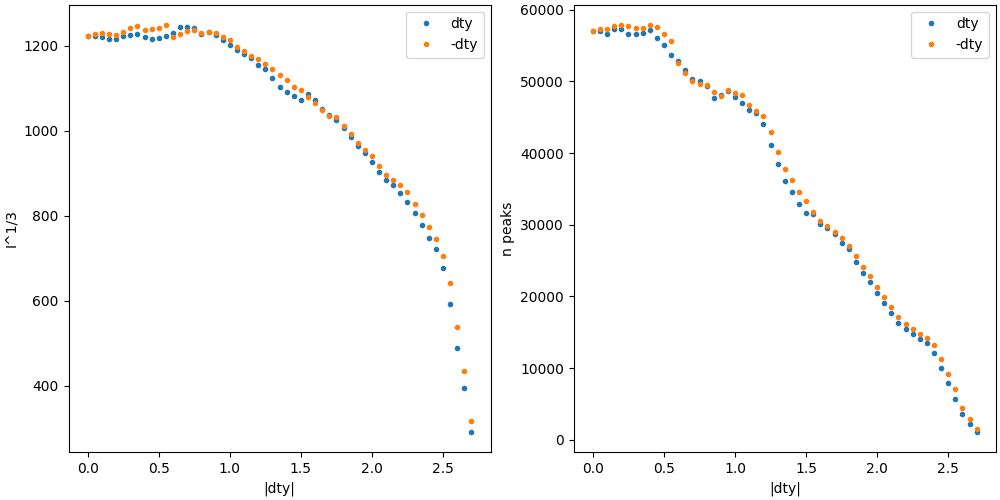

In [51]:
# check dty pairs have roughly the same number of peaks assigned. If not, there is maybe a problem
friedel_pairs.check_y_symmetry(cf, ds, saveplot=False)

For SI3_DT360Z5480, the number of peaks and total intensity match very well in each pair of scans. We also see a decreasing number of peaks and decreasing intensity with increasing distance from the rotation center (dty=0), because the volume illuminated by the beam decreases toward the rim

### Friedel pair labeling

Now we are ready for pairing. We can first try on one pair of scans, to see how it looks. This is done using the function label_friedel_pair from the friedel_pair module. This function searches for nearest neighbors between two symmetric scans in a 4D space formed by coordinates (two-theta, eta, omega, instensity). Multiple iterations of this process are run, applying an increasigly large distance threshold to identify nearest neighbors. 

The two paremters dist_max and dist_step control the distance threshold applied for nearest-neighbor search. At each iteration, the distance threshold is increased of dist_step, until the value dist_max is reached. This distance is expressed in a 4D space formed with coordinates (two-theta, eta, omega, instensity). However, these four dimensions are somewhat different: omega and eta are angles between 0 and 360°, two theta is an angle showing much tighter variations than omega and eta, and intensity is a scalar which can go from zero to a very large number. Therefore, two-theta and instensity are not used directly. Instead, two functions f(two-theta) and g(intensity) are used, to rescale these variables to something closer to eta and omega. mult_fact_tth and mult_fact_I are two scaling parameters that can be adjusted to make all four dimensions comparable.


4500 pairs kept out of  4506  possible matches
14335 pairs kept out of  14528  possible matches
8889 pairs kept out of  9000  possible matches
5488 pairs kept out of  5551  possible matches
3543 pairs kept out of  3577  possible matches
2087 pairs kept out of  2128  possible matches
1371 pairs kept out of  1382  possible matches
882 pairs kept out of  891  possible matches
497 pairs kept out of  510  possible matches
313 pairs kept out of  317  possible matches
Friedel pair identification Completed.
N pairs =  41905  out of  42332 possible candidates
Prop_paired =  0.99
dstep_max= 1.0


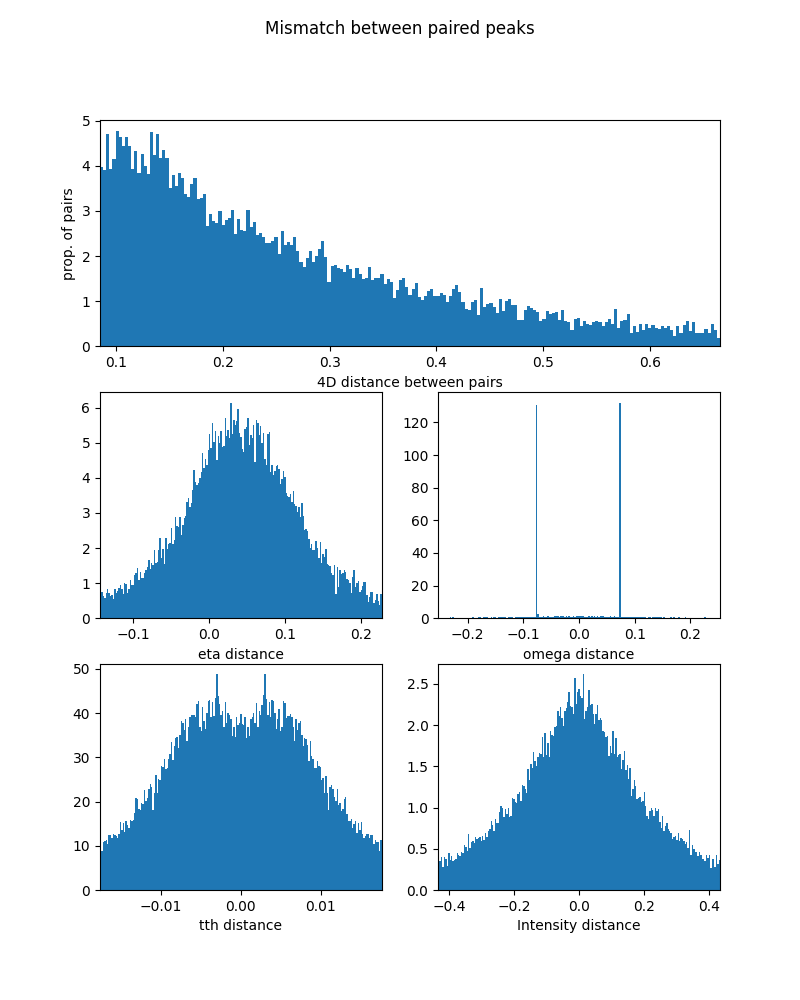

In [52]:
# select peaks from a pair
c1, c2 = friedel_pairs.select_ypair(cf, ds, pair_id = 0)

# friedel pair search. let's try first with these values
cp = friedel_pairs.label_friedel_pairs(c1,c2,
                                  dist_max = 1.,
                                  dist_step = 0.1,
                                  mult_fact_tth = 1/5,
                                  mult_fact_I = 1/25,
                                  verbose=True,
                                  doplot=True)

Setting doplot = True, several things are plotted.

Let's have a look at the output statistics and at these plots. With SI3_DT360Z5480, we see that nearly all peaks have been paired. Great! The different plots show the distribution of distance between two paired peaks in the 4D euclidian space, and along each individual dimension. Ideally, we want the four distributions along each dimension to be approximately the same, so that each variable has similar contribution to the total distance (ie, similar weight in the idnetification of Friedel pairs.  


We see that the spread along two-theta (tth) and intensity are very different from those along eta and omega, so we can adjust the two parameters mult_fact_tth and mult_fact_I to rescale these variables. We can also reduce a bit the dist_max parameter, because nearly all peaks were identified as pairs, and there are likely some false-positives in the last increments of search when the distance threshold is high. 


132 pairs kept out of  132  possible matches
5716 pairs kept out of  5724  possible matches
13302 pairs kept out of  13352  possible matches
8622 pairs kept out of  8685  possible matches
4733 pairs kept out of  4759  possible matches
3026 pairs kept out of  3072  possible matches
2002 pairs kept out of  2024  possible matches
1381 pairs kept out of  1426  possible matches
1022 pairs kept out of  1080  possible matches
650 pairs kept out of  696  possible matches
446 pairs kept out of  464  possible matches
334 pairs kept out of  344  possible matches
270 pairs kept out of  279  possible matches
248 pairs kept out of  260  possible matches
200 pairs kept out of  206  possible matches
182 pairs kept out of  184  possible matches
441 pairs kept out of  461  possible matches
Friedel pair identification Completed.
N pairs =  42707  out of  57045 possible candidates
Prop_paired =  0.75
dstep_max= 0.8500000000000001


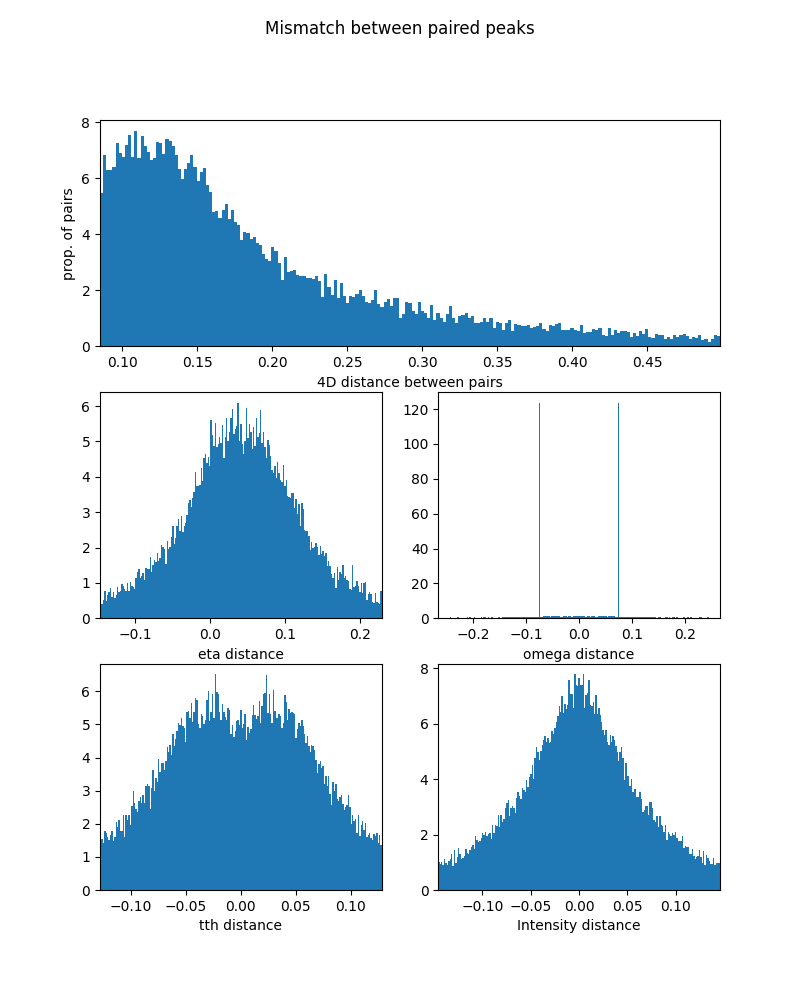

In [60]:
c1, c2 = friedel_pairs.select_ypair(cf, ds, pair_id = 0)

cp = friedel_pairs.label_friedel_pairs(c1,
                                  c2,
                                  dist_max = .85,
                                  dist_step = 0.05,
                                  mult_fact_tth = 1.5,
                                  mult_fact_I = 1/80,
                                  verbose=True,
                                  doplot=True)

Ok, now it looks better. We can use these parameters to do pairing on all ypairs in our dataset. For this, we will use the function find_all_pairs, which iterates label_friedel_pairs on all ypairs in the dataset and then merges all outputs in a single columnfile

In [61]:
cf_paired, fp_labels = friedel_pairs.find_all_pairs(cf,
                                                    ds,
                                                    dist_max=.85,
                                                    dist_step=0.05,
                                                    mult_fact_tth = 1.5,
                                                    mult_fact_I = 1/80,
                                                    verbose=True,
                                                    doplot=False)

Friedel pair search...


100%|██████████| 55/55 [00:47<00:00,  1.16it/s]


Friedel pair search completed.
Updating new Friedel pair labels
Merging peakfiles...


100%|██████████| 54/54 [00:03<00:00, 18.00it/s]

Friedel pairing Completed.
N pairs =  1473324
Prop_paired =  0.76


We end up with ~75% of peaks paired. Not bad.

Now, let's have a look at the new peakfile. It contains two new columns fp_id and fp_dist, which contain respectively the labels of the Friedel pairs, and the 4D distance in (tth,eta,omega,Intensity) between the two peaks of each pair.

In [66]:
cf_paired.titles

['sc',
 'fc',
 'omega',
 's_raw',
 'f_raw',
 'sum_intensity',
 'spot3d_id',
 'xl',
 'yl',
 'zl',
 'tth',
 'eta',
 'gx',
 'gy',
 'gz',
 'ds',
 'dty',
 'number_of_pixels',
 'fp_id',
 'fp_dist']

We can also see that columns have been ordered by fp_id, and each fp_id occurs exactly twice in cf_paired. If you want ot select one peak of each Friedel pair, you can simply select all odd or even indices in a column. e.g. cf_paired.tth[::2] / cf_paired[1::2]

In [68]:
print(cf_paired.fp_id[:20])

np.all(np.equal(cf_paired.fp_id[::2], cf_paired.fp_id[1::2]))

[0 0 1 1 2 2 3 3 4 4 5 5 6 6 7 7 8 8 9 9]


True

We can also plot the distribution of distance in the 4D search space to see how it looks

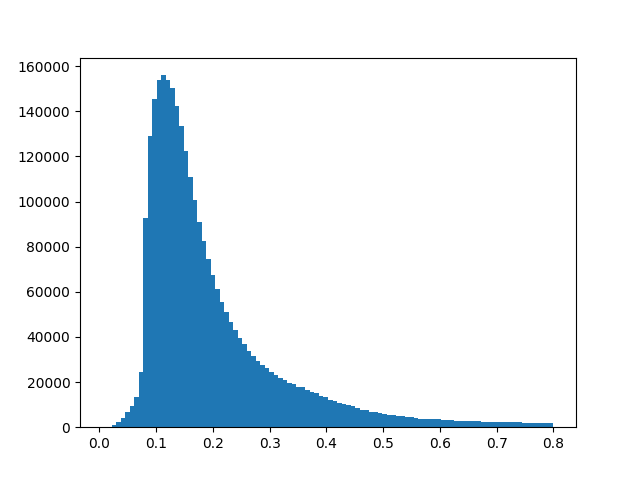

In [69]:
pl.figure()
pl.hist(cf_paired.fp_dist,100);

We see that fp_dist, the 4D distance between two peaks of each pair, is mostly concentrated between 0.05 and 0.4, and decreases sharply afterwards. There is a small bump around 0.8, which likely results from the fact that at such high distance threshold, peaks corresponding to different two-theta rings or different angular steps were paired together. This is probably dodgy, so we will cut these high values.

In [70]:
cf_paired.filter(cf_paired.fp_dist < 0.8)

### Geometry correction
Now we have friedel pairs labeled, we can start doing useful stuff with them!

If a grain is not on the rotation centre but translated of some vector t(dx, dy, dz) from the center, this will result in an offset on the detector and inaccurate 2-theta and eta values. In a classic indexing procedure, t, eta and 2-theta are fitted a-posteriori, after indexing. With Friedel pairs, we can do this before, which will make indexing much easier.

In a scanning 3DXRD experiment using a thin pencil beam, the beam dimension in y and z is small, and thus we can consider that grain offset only occurs along the beam, ie. in the x-direction. This means that only 2-theta (tth) is modified by this offset, not eta. We also know dy, which is basically the translation dty during scanning, which is stored in dty column. With these assumptions, we find that for two peaks (p1,p2) forming a Friedel pair:

- tth_cor = 1/2.(tan1 + tan2)
- dx = L * (tan1-tan2)/(tan1+tan2)

where tan1 and tan2 are respectively tan(tth1) and tan(tth2) of p1 and p2 and L the detector distance from the rotation center. Thus, we get tth_cor, the "real" 2-theta angle accounting only for d-spacing in the crystal and not the for offset from the rotation centre.

dx and dy need to be back-rotated of an angle omega in order to put them in the sample reference frame, and give the position (xs,ys) of the grain in the sample, wich will then be used for point-by-point fit.

We will use the function update_geometry_s3dxrd from the friedel_pairs module to compute these values

In [71]:
friedel_pairs.update_geometry_s3dxrd(cf_paired, detector = 'frelon', update_gvecs=True) 

Now let's have a look on the data. We can first try to plot 2-theta vs. eta for corrected vs non-corrected tth. 

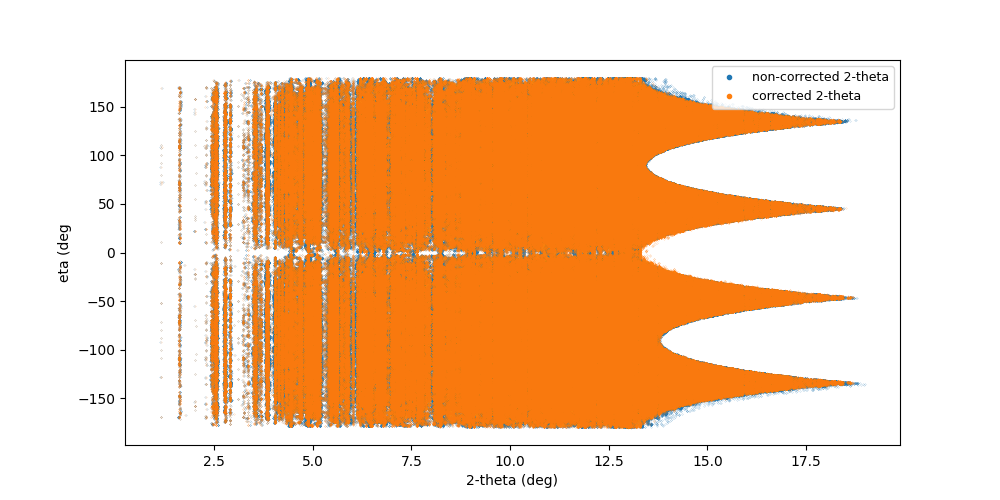

In [77]:
pl.figure(figsize=(10,5))
pl.plot(cf_paired.tth, cf_paired.eta, '.', ms = .2, label='non-corrected 2-theta') 
pl.plot(cf_paired.tthc, cf_paired.eta, '.', ms=.2, label='corrected 2-theta')
pl.xlabel('2-theta (deg)')
pl.ylabel('eta (deg')
pl.xlim(3.25,5.25)

pl.legend(markerscale=30, loc='upper right', fontsize=9) 


#### Comparison with computed hkl rings

There is a sharp reduction of the spread in 2-theta using corrected peak coordinates, and we see sharp ring appearing. Now we want to see if these rings match with predicted 2-theta position for the differnet phases in the sample. This can be done by using multiple parameter files in ImageD11, loading them and computing successively 2-theta positions of hkl rings for each phase. This is ok for one or two phases, but rapidly becomes impractical with more complex samples.

Instead, we will use the module crystal_structure.py This module is built upon other python packages for X-ray diffraction data, namely diffpy.structure, Dans_Diffraction and orix. It defines a CS (for crystal_structure) class, which allows to store crystal structure information directly loaded from a cif file.

In [75]:
from custom_3DXRD_module import crystal_structure

In [76]:
# let's define a dictionary with all our phases. Here we assume that we already know what are the phases in the sample, but it might be something we want to determine as well
phase_names = ['quartz', 'orthoclase', 'oligoclase', 'biotite', 'magnetite']
phase_dict = {}

for i,p in enumerate(phase_names):
    cs = crystal_structure.load_CS_from_cif(cif_path = f'cif/{p}.cif', name=p, pid=i)
    print(cs)
    phase_dict[p] = cs

CS: quartz, phase_id: 0, spg: P3221, spg_no: 154, lattice: [4.91325, 4.91325, 5.41206, 90.0, 90.0, 120.0]
CS: orthoclase, phase_id: 1, spg: C1-11, spg_no: 12, lattice: [8.589, 13.013, 7.197, 90.0, 116.02, 90.0]
CS: oligoclase, phase_id: 2, spg: C-1, spg_no: 2, lattice: [8.154, 12.823, 7.139, 94.06, 116.5, 88.59]
CS: biotite, phase_id: 3, spg: C12/m1, spg_no: 12, lattice: [5.355, 9.251, 10.246, 90.0, 100.15, 90.0]
CS: magnetite, phase_id: 4, spg: Fd3m, spg_no: 227, lattice: [8.3965, 8.3965, 8.3965, 90.0, 90.0, 90.0]


We want to compute theoretical 2-theta rings for all these phases. We need to know the wavelength, which is in the parameter file. It is possible to get directly these values with ImageD11, but we will use a bit more fancy way here, which happens to be quite usefull when dealing with complex mixtures of low-symmetry phases: first, we compute a simulated powder spectrum, and then we run a peaksearch on this spectrum to find the N-strongest peaks. This allows to retain only the most significant peaks, and not care about all the numerous, very low intensity peaks which theoretically exist but are practically barely visible.

Scatter(quartz with 2 atomic positions, 6 symmetries)
       Type: x-ray
     Energy: 43.57356018082551 keV
 Wavelength: 0.28454050670689945 A
 ---Settings---
      Powder units: tth
    Isotropic ADPs: True
  Specular Direction (reflection): ( 0, 0, 1)
Parallel Direction (transmission): ( 0, 0, 1)
      theta offset: 0.0
         min theta: -180.0
         max theta: 180.0
      min twotheta: 2
      max twotheta: 15
 ---X-Ray Settings---
 Waasmaier scattering factor: False
 ---Magnetic Settings---
   Mag. scattering: True
  Mag. form factor: True
         Polarised: False
      Polarisation: sp
       Pol. vector: (0,1,0)
 ---Resonant Settings---
   Azimuthal angle: 0
    Azimuthal ref.: (1,0,0)
               flm: (0,1,0)
  use e1e1 approx.: True

Scatter(orthoclase with 18 atomic positions, 4 symmetries)
       Type: x-ray
     Energy: 43.57356018082551 keV
 Wavelength: 0.28454050670689945 A
 ---Settings---
      Powder units: tth
    Isotropic ADPs: True
  Specular Direction (refl

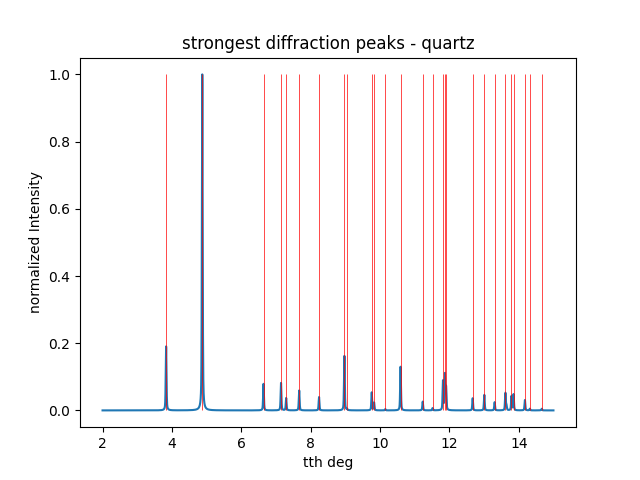

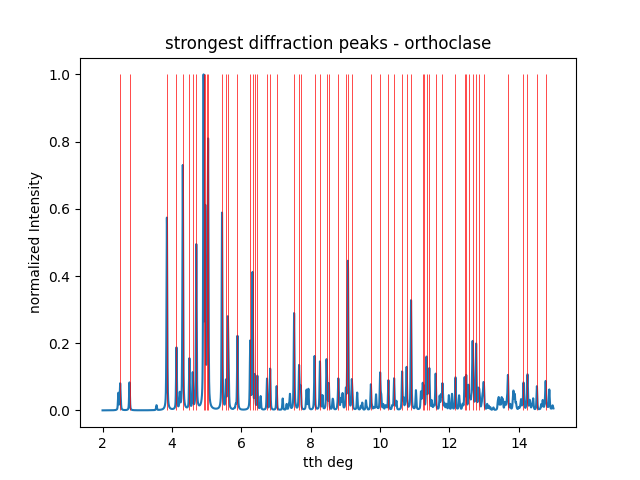

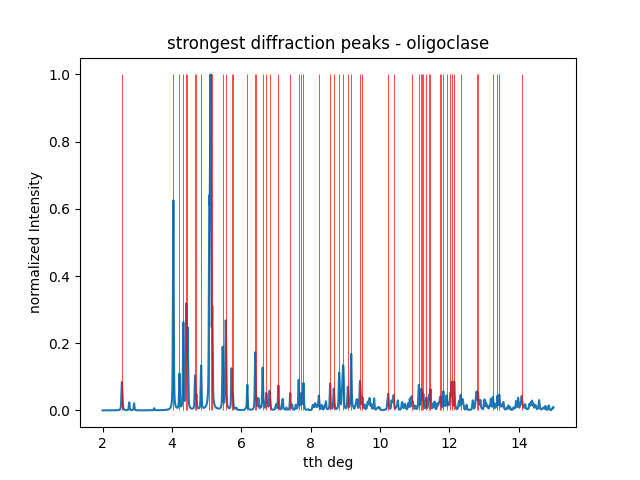

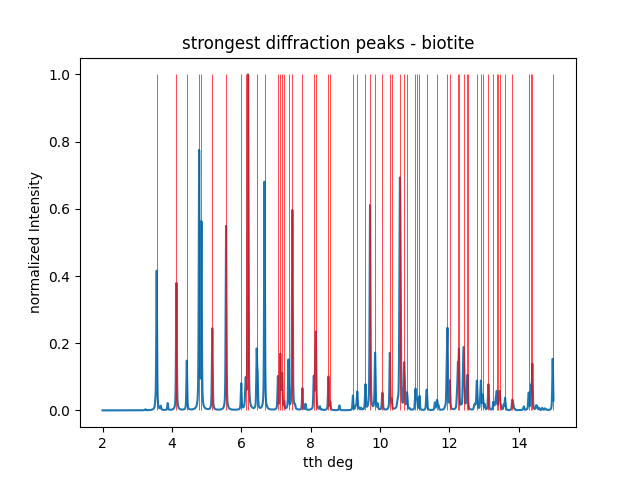

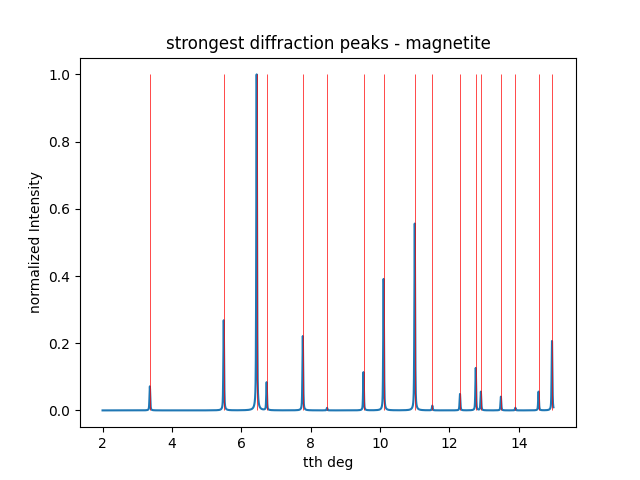

In [78]:
wl = cf.parameters.get('wavelength')

for cs in phase_dict.values():
    cs.compute_powder_spec(wl, min_tth=2, max_tth=15, doplot=False)
    cs.find_strongest_peaks(Imin=0.001, Nmax=60, doplot=True)

Now we can replot the data with these theoretical peaks

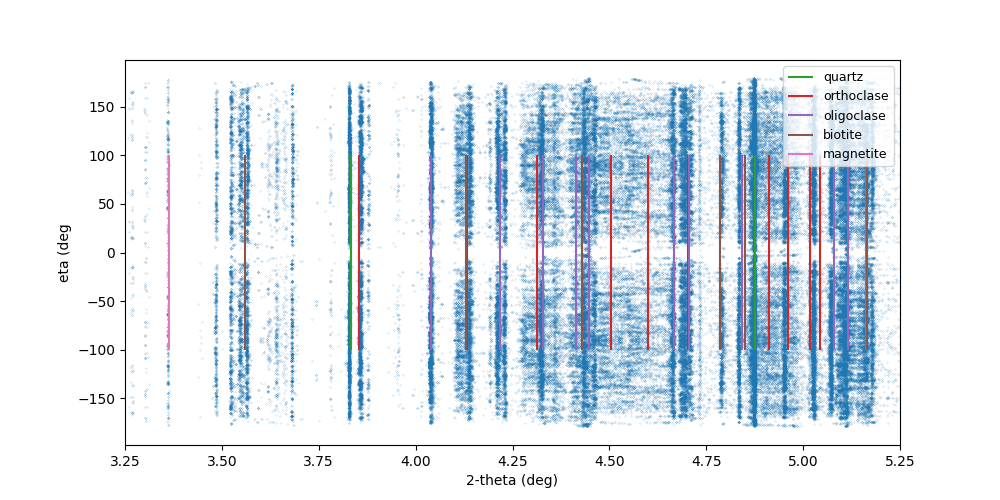

In [81]:
colors = pl.matplotlib.cm.tab10.colors

pl.figure(figsize=(10,5))
pl.plot(cf_paired.tthc, cf_paired.eta, '.', ms=.2)

for p,cs in phase_dict.items():
    pl.vlines(cs.strong_peaks[0], -100,100, colors = colors[cs.phase_id+2], label=p)
pl.xlabel('2-theta (deg)')
pl.ylabel('eta (deg')
pl.xlim(3.25, 5.25)

pl.legend(loc='upper right', fontsize=9) 

There is a slight mismatch especially for orthoclase rings. Keep in mind that these phases are solid solutions which can vary quite a lot in composition across the sample, with some influence on the lattice parameters, so perfectly matching these phases can be quite difficult. 

### Sample reconstruction

There is a last thing we can do in this first part of the tutorial. In addition to corrected 2-theta, we also have the (xs,ys) origin of each diffraction peaks in the sample reference frame. Let's try to plot these data in a 2D histogram

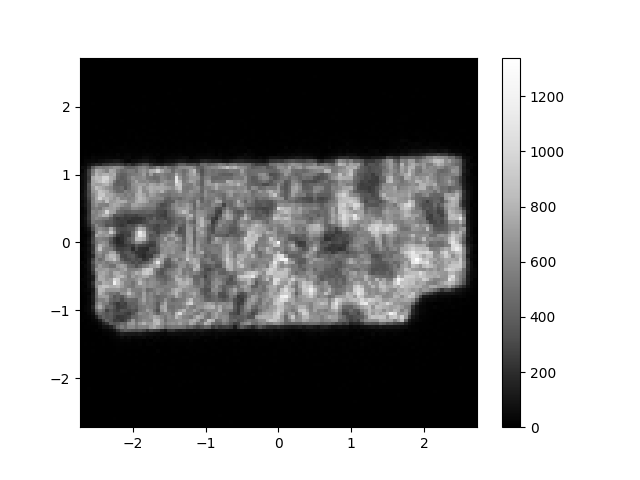

In [82]:
pl.figure()
cmap = pl.matplotlib.cm.Greys_r.copy()
cmap.set_extremes(under='k', over='w')

pl.hist2d(cf_paired.xs, cf_paired.ys, bins = ds.ybinedges, cmap=cmap);
pl.colorbar()

And we get a nice map of the sample! We can filter out peaks outside the ROI, to keep only portions of the map with complete data

In [83]:
cf_paired.filter(cf_paired.r_dist <= ds.ybinedges.max())

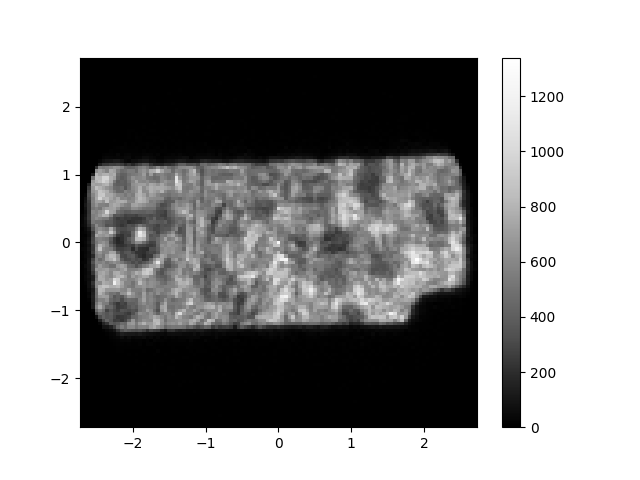

In [84]:
pl.figure()

pl.hist2d(cf_paired.xs, cf_paired.ys, bins = ds.ybinedges, cmap=cmap);
pl.colorbar()

There is also a function in the utils module to make this plot. It allows to select only subsets of peaks for plotting, e.g, a small rectangle in the sample, or a subset corresponding to one single phase. Let's try it with quartz.

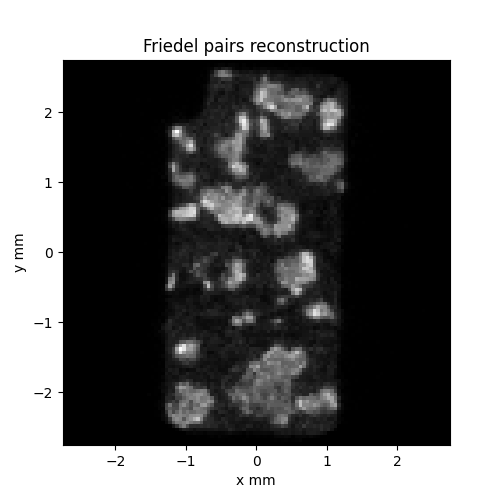

In [91]:
# compute mask for quartz
mask_qtz = utils.select_tth_rings(cf_paired, phase_dict['quartz'].strong_peaks[0], tth_tol=0.02, tth_max=15, is_sorted=False)
kw = {'cmap':'Greys_r'}   # keyword arg to pass to plot function

# plot reconstruction for quartz peaks only
utils.friedel_recon(cf_paired,
                    xbins = ds.ybinedges,
                    ybins = ds.ybinedges,
                    doplot=True,
                    mask = mask_qtz,
                    weight_by_intensity=True,
                    norm = True,
                    **kw );

We clearly see the quartz grains appearing, but there is still some signal from outside of these grains. This results from overlaps between different 2-theta rings from different phases, which inevitably results in wrong selection of some peaks. In the next tutorial, we will see how we can improve that and make a decent phase map. 

To finish, we need to save these data somewhere. There is a function in ImageD11.columnfile to export columnfiles, but we will use here the custom function from custom_3DXRD_module.utils, which does basically the same but make sure that essential information (namely, fp_id and fp_dist) are saved. 

In [94]:
# save data. The 'minimal' save mode means that only the necessary data columns are kept. All data that can be recomputed from other columns are dropped.
utils.colf_to_hdf(cf_paired, os.path.join(data_dir, dsname+'_pks_p.h5'), save_mode='minimal')